In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import lumicks
import lumicks.pylake as lk
%matplotlib inline
from skimage.transform import rescale
import tifffile
from PIL import Image
import os

def norm_image(image,inverse=False):
    amin = image.min()
    amax = image.max()
    if inverse:
        return 1- (image-amin)/(amax-amin)    
    else:
        return (image-amin)/(amax-amin)
    


In [2]:

directory = "data/output"

# Check if the directory already exists
if not os.path.exists(directory):
    # Create the directory
    os.makedirs(directory)
    print("Directory created successfully!")
else:
    print("Directory already exists!")

Directory created successfully!


In [3]:
irm_path="data/20231228-A_IRM_0.5_beads.tif"
wt_path="data/20231228-A_WT_0.5_beads.tif"

irm = lk.ImageStack(irm_path)  # Loading a stack.
wt = lk.ImageStack(wt_path)  # Loading a stack.

#wt_exp_path="data/20231228-A_WT_0.5_beads_export.tif"
#wt.export_tiff(wt_exp_path)



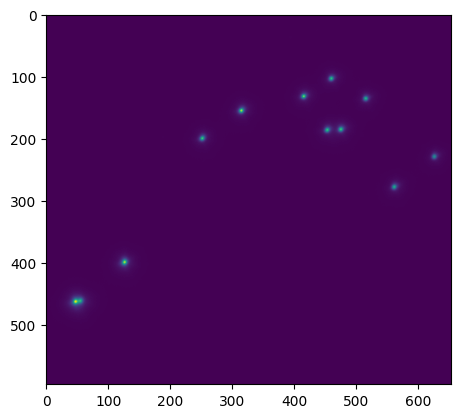

In [4]:
wt_g = wt.get_image(channel='green')
wt_r = wt.get_image(channel='red')
wt_b = wt.get_image(channel='blue')
plt.imshow(wt_g)


irm_g = irm.get_image()


In [5]:
wt_metadata=wt._tiff_image_metadata()
wt_roi=wt_metadata['Alignment region of interest (x, y, width, height)']
print(wt_roi)

irm_metadata=irm._tiff_image_metadata()
irm_roi=irm_metadata['Region of interest (x, y, width, height)']   #This is different because the wt was previously aligned I think. Can this cause issues?
print(irm_roi)

[639, 60, 654, 597]
[0, 0, 728, 544]


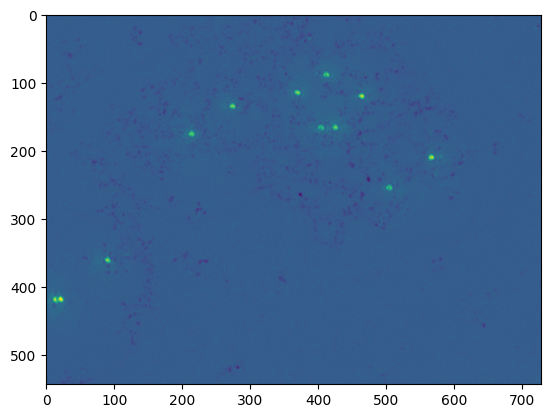

In [6]:
#wt_roi=(0,0)#testing no padding  edit:Apparently it works if you don't pad it?
#irm_roi=(0,0)

wt_g_padded=np.pad(wt_g, [(int(wt_roi[0]),0),(int(wt_roi[1]),0)])
plt.imshow(wt_g_padded)
tifffile.imwrite('data/output/wt_padded.tif',wt_g_padded)

irm_g_padded=np.pad(irm_g, [(int(irm_roi[0]),0),(int(irm_roi[1]),0)])
tifffile.imwrite('data/output/irm_padded.tif',irm_g_padded)
plt.imshow(irm_g_padded)

In [7]:
#Gradient needs to be adjusted. In dataset A it needs to be 60000, but because of a speck, in B dataset it needs to be 700000 (note the extra 0)
#dataset 20240103-134127_WT needs 70000

!python -m picasso localize data/output/wt_padded.tif --fit-method lq -b 21 --gradient 70000
!python -m picasso localize data/output/irm_padded.tif --fit-method lq -b 21 --gradient 70000


    ____  _____________   __________ ____ 
   / __ \/  _/ ____/   | / ___/ ___// __ \
  / /_/ // // /   / /| | \__ \\__ \/ / / /
 / _____/ // /___/ ___ |___/ ___/ / /_/ / 
/_/   /___/\____/_/  |_/____/____/\____/  
                                          
Localize - Parameters:
No       Label           Value     
1        command         localize  
2        files           data/output/wt_padded.tif
3        box_side_length 21        
4        fit_method      lq        
5        gradient        70000     
6        drift           1000      
7        roi             None
8        baseline        0         
9        sensitivity     1         
10       gain            1         
11       qe              1         
12       mf              0         
13       pixelsize       130       
14       zc                        
15       suffix                    
16       database        0         
------------------------------------------
Namespace(command='localize', files='data/output/wt_pad


LQ fitting: 100%|██████████| 1200/1200 [00:19<00:00, 62.16task/s] 

Generating segments: 0segments [00:00, ?segments/s]
Generating segments: 0segments [00:00, ?segments/s]

Correlating image pairs: 0pairs [00:00, ?pairs/s]
Correlating image pairs: 0pairs [00:00, ?pairs/s]


    ____  _____________   __________ ____ 
   / __ \/  _/ ____/   | / ___/ ___// __ \
  / /_/ // // /   / /| | \__ \\__ \/ / / /
 / _____/ // /___/ ___ |___/ ___/ / /_/ / 
/_/   /___/\____/_/  |_/____/____/\____/  
                                          
Localize - Parameters:
No       Label           Value     
1        command         localize  
2        files           data/output/irm_padded.tif
3        box_side_length 21        
4        fit_method      lq        
5        gradient        70000     
6        drift           1000      
7        roi             None
8        baseline        0         
9        sensitivity     1         
10       gain            1         
11       qe              1         
12       mf              0         
13       pixelsize       130       
14       zc                        
15       suffix                    
16       database        0         
------------------------------------------
Namespace(command='localize', files='data/output/irm_p


LQ fitting: 100%|██████████| 1200/1200 [00:20<00:00, 59.10task/s]

Generating segments: 0segments [00:00, ?segments/s]
Generating segments: 0segments [00:00, ?segments/s]

Correlating image pairs: 0pairs [00:00, ?pairs/s]
Correlating image pairs: 0pairs [00:00, ?pairs/s]


In [8]:
from cv2 import estimateAffine2D,estimateAffinePartial2D
from picasso import io, postprocess


irm_locs, irm_info = io.load_locs("data/output/irm_padded_locs.hdf5")
wt_locs, wt_info = io.load_locs("data/output/wt_padded_locs.hdf5")
print(wt_locs)
print(irm_locs)

[(0, 109.61007, 1102.0815 , 2642598.5 , 5.4418564, 3.6116762, 2080.7595 , 0.00729147, 0.00449932, 0.33631542, 1258179.8 )
 (0, 186.38982, 1038.8177 , 1331391.5 , 2.9464188, 3.2530925, 1805.6866 , 0.00522878, 0.00585739, 0.09427145, 1132535.8 )
 (0, 312.02124,  838.9168 ,  898312.94, 2.7305355, 2.8533857, 1173.8728 , 0.00583064, 0.0061239 , 0.04305418,  855659.5 )
 (0, 375.09955,  794.1984 , 1104078.9 , 2.7645833, 2.810001 , 1446.6655 , 0.00533315, 0.00543094, 0.01616282, 1052487.6 )
 (0, 475.80334,  771.1518 ,  940448.6 , 2.7228663, 2.7056947, 1268.7766 , 0.00569196, 0.00565206, 0.00630645,  921380.9 )
 (0, 513.84326,  825.4468 ,  882598.4 , 2.8479393, 2.8168957, 1361.1661 , 0.00623757, 0.00616023, 0.01090035,  815312.9 )
 (0, 520.3099 ,  742.4194 ,  821680.2 , 2.7178848, 2.7374046, 1048.5221 , 0.0060565 , 0.00610468, 0.00713077,  787400.5 )
 (0, 535.7396 ,  824.43835,  911261.8 , 2.829993 , 2.8402185, 1485.831  , 0.00612076, 0.0061461 , 0.00360026,  842354.06)
 (0, 576.011  ,  774.726

In [9]:
wt_locs = wt_locs[wt_locs["sx"]<3.5]
wt_locs = wt_locs[wt_locs["sy"]<3.5]
irm_locs = irm_locs[irm_locs["sx"]<3.5]
irm_locs = irm_locs[irm_locs["sy"]<3.5]
#wt_locs = wt_locs[wt_locs["photons"]<1500000]
#irm_locs = irm_locs[irm_locs["photons"]<1500000]

import math

wt_locs_xy=wt_locs[["x","y"]].copy()
irm_locs_xy=irm_locs[["x","y"]].copy()


wt_locs_xy = np.vstack([wt_locs_xy[item] for item in ['x','y']]).T.astype(np.int64) #Parse to numpy array:
irm_locs_xy = np.vstack([irm_locs_xy[item] for item in ['x','y']]).T.astype(np.int64)

print(len(wt_locs_xy))   #These need to be the same
print(len(irm_locs_xy))



10
10


In [10]:
#Delete points that are too close. ugly, but it works. Is there a better way?
#This became obsolete with making the box larger, but i'll leave it here in case it's useful

import itertools

delete_pair_list=[]
for index1,point1 in enumerate(irm_locs_xy):
    for index2,point2 in enumerate(irm_locs_xy):
        if (index1!=index2):
            distance=math.sqrt((point1[0]-point2[0])*(point1[0]-point2[0])+(point1[1]-point2[1])*(point1[1]-point2[1]))
            #print(distance)
            if distance < 5:
                print("found")
                delete_pair_list.append(sorted((index1,index2)))  #this array holds pair of point indexes that are too close


delete_pair_list.sort()
delete_pair_list=list(delete_pair_list for delete_pair_list,_ in itertools.groupby(delete_pair_list))

delete_index_list=[]
for pair in delete_pair_list:
    if irm_locs_xy[pair[0]][1]>irm_locs_xy[pair[1]][1]: 
        delete_index_list.append(pair[0])#if first item in pair is to the right, delete that one
    else:
        delete_index_list.append(pair[1]) #otherwise, this one

print(len(irm_locs_xy))
irm_locs_xy=np.delete(irm_locs_xy,delete_index_list,axis=0)
print(len(irm_locs_xy))

##Repeat for wt
delete_pair_list=[]
for index1,point1 in enumerate(wt_locs_xy):
    for index2,point2 in enumerate(wt_locs_xy):
        if (index1!=index2):
            distance=math.sqrt((point1[0]-point2[0])*(point1[0]-point2[0])+(point1[1]-point2[1])*(point1[1]-point2[1]))
            #print(distance)
            if distance < 5:
                print("found")
                delete_pair_list.append(sorted((index1,index2)))  #this array holds pair of point indexes that are too close


delete_pair_list.sort()
delete_pair_list=list(delete_pair_list for delete_pair_list,_ in itertools.groupby(delete_pair_list))

delete_index_list=[]
for pair in delete_pair_list:
    if wt_locs_xy[pair[0]][1]>wt_locs_xy[pair[1]][1]: 
        delete_index_list.append(pair[0])#if first item in pair is to the right, delete that one
    else:
        delete_index_list.append(pair[1]) #otherwise, this one

print(len(wt_locs_xy))
wt_locs_xy=np.delete(wt_locs_xy,delete_index_list,axis=0)
print(len(wt_locs_xy))




10
10
10
10


In [11]:
a=estimateAffinePartial2D(wt_locs_xy,irm_locs_xy)

#This was a test to see if it works with extra points. It doesn't.

#wt_locs_xy_00=np.vstack([wt_locs_xy, (0,0)])
#wt_locs_xy_00
#a=estimateAffinePartial2D(wt_locs_xy_00,irm_locs_xy)


In [12]:
from cv2 import warpAffine,invertAffineTransform
from pathlib import Path

transform_mat=a[0]
transform_mat_inverted=invertAffineTransform(a[0])

irm_g_padded_warped=warpAffine(irm_g_padded,transform_mat_inverted,(irm_g_padded.shape[1], irm_g_padded.shape[0]))

#plt.imshow(irm_g_padded_warped, alpha=0.5)
#plt.imshow(wt_g_padded, alpha=0.5)

#Print inverted matrix result to file so that I can compare them
np.savetxt("data/output/"+Path(irm_path).stem+"_matrix.txt", transform_mat_inverted)

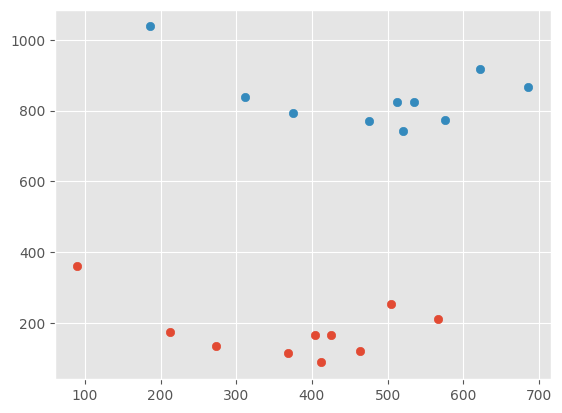

In [13]:
#Draw unaligned points
import matplotlib.pyplot as plt
plt.scatter(*zip(*irm_locs_xy))
plt.scatter(*zip(*wt_locs_xy))


In [59]:
#Manually affine transform the points

transform_mat_inverted_for_points=np.vstack([transform_mat_inverted,(0,0,1)])

warped_irm_locs=[]

for point in irm_locs_xy:
    new_point=(point[0],point[1],1)
    #print(new_point)
    transformed_point=np.matmul(transform_mat_inverted_for_points,new_point)
    new_point=(transformed_point[0],transformed_point[1])
    warped_irm_locs.append(new_point)
warped_irm_locs=np.array(warped_irm_locs)
print(warped_irm_locs)

[[ 185.6441708  1037.98719172]
 [ 311.77747108  838.51283378]
 [ 374.38060735  793.83199281]
 [ 475.53103675  770.59439524]
 [ 513.69008433  824.86197196]
 [ 520.46973123  742.15320806]
 [ 535.91128406  824.40816411]
 [ 575.12701875  774.91197905]
 [ 621.40699217  915.81839057]
 [ 686.06160349  867.9198727 ]]


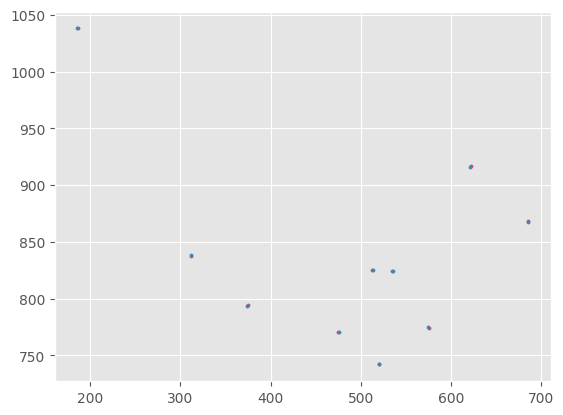

In [18]:
#Plot aligned points
plt.scatter(*zip(*wt_locs_xy),s=5)
#plt.scatter(*zip(*irm_locs_xy),s=3)
plt.scatter(*zip(*warped_irm_locs),s=5)

In [60]:
#Get RMSD

wt_locs_xy_sorted=wt_locs_xy[np.lexsort((wt_locs_xy[:,1], wt_locs_xy[:,0]))]                        #Sort the points in case they are in different orders
warped_irm_locs_sorted=warped_irm_locs[np.lexsort((warped_irm_locs[:,1], warped_irm_locs[:,0]))]

rmsd = np.sqrt(((((wt_locs_xy_sorted - warped_irm_locs_sorted)** 2))*3).mean())
print(rmsd)



0.9787226143737272
0.9787226143737272
